In this mini-lecture, we begin the journey on studying interpretable machine learning models. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os
import random
import sklearn as sk

from PyALE import ale
from sklearn.datasets import make_hastie_10_2  # generating data for binary classification used in Hastie et al. 2009, Example 10.2.
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.inspection import plot_partial_dependence
from sklearn.datasets import load_iris

%matplotlib inline

In [2]:
# path="C:\\Users\\gao\\GAO_Jupyter_Notebook\\Datasets"
# os.chdir(path)

path="C:\\Users\\pgao\\Documents\\PGZ Documents\\Programming Workshop\\PYTHON\\Open Courses on Python\\Udemy Course on Python\Introduction to Data Science Using Python\\datasets"
os.chdir(path)

### I. The Notion of Machine Learning Interpretability

Methods for machine learning interpretability can be classified according to various criteria. For example, one can categorize interpretability based on whether it's intrinsic or post hoc. In other words, this criteria distinguishes whether interpretability is achieved by restricting the complexity of the machine learning model (intrinsic) or by applying methods that analyze the model after training (post hoc). Intrinsic interpretability refers to machine learning models that are considered interpretable due to their simple structure, such as short decision trees or sparse linear models. Post hoc interpretability refers to the application of interpretation methods after model training. **Permutation feature importance** (see the sklearn library in Python) is, for example, a post hoc interpretation method. Post hoc methods can also be applied to intrinsically interpretable models. For example, permutation feature importance can be computed for decision trees. 

The various interpretation methods can also be roughly differentiated according to their results:
   1. Feature summary statistic: many interpretation methods provide summary statistics for each feature. Some methods return a single number per feature, such as feature importance, or a more complex result, such as the **pairwise feature interaction strengths**, which consist of a number for each feature pair.
   2. Feature summary visualization: most of the feature summary statistics can also be visualized. Some feature summaries are actually only meaningful if they are visualized and a table would be a wrong choice. The partial dependence of a feature is such a case. Partial dependence plots are curves that show a feature and the average predicted outcome. The best way to present partial dependences is to actually draw the curve instead of printing the coordinates.
   3. Model internals (e.g. learned weights): the interpretation of intrinsically interpretable models falls into this category. Examples are the weights in linear models or the learned tree structure (the features and thresholds used for the splits) of decision trees. The lines are blurred between model internals and feature summary statistic in, for example, linear models, because the weights are both model internals and summary statistics for the features at the same time. Interpretability methods that output model internals are by definition model-specific.
   4. Data point: this category includes all methods that return data points (already existent or newly created) to make a model interpretable. One method is called **counterfactual explanations**. To explain the prediction of a data instance, the method finds a similar data point by changing some of the features for which the predicted outcome changes in a relevant way (e.g. a flip in the predicted class). Another example is the **identification of prototypes of predicted classes**. To be useful, interpretation methods that output new data points require that the data points themselves can be interpreted. This works well for images and texts, but is less useful for tabular data with hundreds of features.
   
There are other taxanomies on interpretability. One way to look at the issue is to ask whether interpretability is model-specific or model-agnostic. Model-specific interpretation tools are limited to specific model classes. The interpretation of regression weights in a linear model is a model-specific interpretation, since by definition, the interpretation of intrinsically interpretable models is always model-specific. Tools that only work for the interpretation of e.g. neural networks are model-specific. Model-agnostic tools can be used on any machine learning model and are applied after the model has been trained (post hoc). These agnostic methods usually work by analyzing feature input and output pairs. By definition, these methods cannot have access to model internals such as weights or structural information.

It also makes sense to ask the question of whether the interpretability of a model is global or local. A naive Bayes model with many hundreds of features would be too big for me and you to keep in our working memory. And even if we manage to memorize all the weights, we would not be able to quickly make predictions for new data points. In addition, you need to have the joint distribution of all features in your head to estimate the importance of each feature and how the features affect the predictions on average. But you can easily understand a single weight. While global model interpretability is usually out of reach, there is a good chance of understanding at least some models on a modular level. Not all models are interpretable at a parameter level. For linear models, the interpretable parts are the weights, for trees it would be the splits (selected features plus cut-off points) and leaf node predictions. Linear models, for example, look like as if they could be perfectly interpreted on a modular level, but the interpretation of a single weight is interlocked with all other weights. The interpretation of a single weight always comes with the footnote that the other input features remain at the same value, which is not the case with many real applications. A linear model that predicts the value of a house, that takes into account both the size of the house and the number of rooms, can have a negative weight for the room feature. It can happen because there is already the highly correlated house size feature. In a market where people prefer larger rooms, a house with fewer rooms could be worth more than a house with more rooms if both have the same size. The weights only make sense in the context of the other features in the model. But the weights in a linear model can still be interpreted 'better' than the weights of a deep neural network.

You can zoom in on a single instance and examine what the model predicts for this input, and explain why. If you look at an individual prediction, the behavior of the otherwise complex model might behave more pleasantly. Locally, the prediction might only depend linearly or monotonically on some features, rather than having a complex dependence on them. For example, the value of a house may depend nonlinearly on its size. But if you are looking at only one particular 100 square meters house, there is a possibility that for that data subset, your model prediction depends linearly on the size. You can find this out by simulating how the predicted price changes when you increase or decrease the size by 10 square meters. Local explanations can therefore be more accurate than global explanations. 

There is no real consensus about what interpretability is in machine learning. Nor is it clear how to measure it. But there is some initial research on this and an attempt to formulate some approaches for evaluation. Doshi-Velez and Kim (2017) propose three main levels for the evaluation of interpretability:

   1. Application level evaluation (real task): put the explanation into the product and have it tested by the end user. Imagine fracture detection software with a machine learning component that locates and marks fractures in X-rays. At the application level, radiologists would test the fracture detection software directly to evaluate the model. This requires a good experimental setup and an understanding of how to assess quality. A good baseline for this is always how good a human would be at explaining the same decision.
   2. Human level evaluation (simple task): this is a simplified application level evaluation. The difference is that these experiments are not carried out with the domain experts, but with laypersons. This makes experiments cheaper (especially if the domain experts are radiologists) and it is easier to find more testers. An example would be to show a user different explanations and the user would choose the best one.
   3. Function level evaluation (proxy task): this does not require humans. This works best when the class of model used has already been evaluated by someone else in a human level evaluation. For example, it might be known that the end users understand decision trees. In this case, a proxy for explanation quality may be the depth of the tree. Shorter trees would get a better explainability score. It would make sense to add the constraint that the predictive performance of the tree remains good and does not decrease too much compared to a larger tree.
   
We want to explain the predictions of a machine learning model. To achieve this, we rely on some explanation method, which is an algorithm that generates explanations. An explanation usually relates the feature values of an instance to its model prediction in a humanly understandable way. Other types of explanations consist of a set of data instances (e.g in the case of the K-nearest neighbor model). For example, we could predict cancer risk using a support vector machine and explain predictions using the **local surrogate method (LIME)**, which generates decision trees as explanations. Or we could use a linear regression model instead of a support vector machine. The linear regression model is already equipped with an explanation method (interpretation of the weights).

Robnik-Sikonja and Bohanec (2018) offered some a summary of properties of explanations. These properties can be used to judge how good an explanation method or explanation is. It is not clear for all these properties how to measure them correctly, so one of the challenges is to formalize how they could be calculated. This is an active area of ML research. We will not elaborate here. The online book "Interpretable Machine Learing: A Guide for Making Black Box Method Explainable" by Christoph Molnar has an in-depth discussion about this.  

### II. Some Examples of Interpretable Models

##### 1. Linear Models

There are many interpretable models we have seen. For example, Linear regression, logistic regression and the decision tree are commonly used interpretable models. Majority of these interpretable models are interpretable on a modular level, with the exception of the K-nearest neighbors method. We will go over a few examples quickly. 

A linear regression model predicts the target as a weighted sum of the feature inputs. The linearity of the learned relationship makes the interpretation easy. The regression coefficients have a natural interpretation, whether they are associated with numeric or categorical data. R-squared tells us how much of the total variance of our target outcome is explained by the model, whereas the SSE tells us how much variance remains after fitting the linear model ($SSE=\sum_{i=1}^{n}(y_{i}-\hat{y_{i}})^{2}$). The importance of a feature in a linear regression model can be measured by the absolute value of its t-statistic.

There are certainly disadvantages of using linear models. For example, linear regression models can only represent linear relationships, i.e. a weighted sum of the input features. Each nonlinearity or interaction has to be hand-crafted and given explicitly to the model as an input feature. The interpretation of a weight can be unintuitive because it depends on all other features. A feature with high positive correlation with the outcome and another feature might get a negative weight in the linear model, because given the other correlated feature, it is negatively correlated with the outcome in the high-dimensional space. Completely correlated features make it even impossible to find a unique solution for the linear equation (multicollinearity). 

##### 2. Logistic Models

Logit model is most popular model for classification problems. The interpretation of the weights in logistic regression differs from the interpretation of the weights in linear regression. The weights do not influence the probability linearly any longer. The weighted sum is transformed by the logistic function to a probability. Therefore we need to reformulate the equation for the interpretation so that only the linear term is on the right side of the formula : $log(\frac{Pr(y=1|x)}{Pr(y=0|x)})=x'\beta$. We call the term in the log() function **odds** (probability of event divided by probability of no event) and wrapped in the logarithm it is called **log odds**. The interpretation of the coefficient is that a change in a covariate $x_{k}$ by one unit increases the log odds ratio by the value of the corresponding weight. For numerical features, if you increase the value of feature $x_{k}$ by one unit, the estimated odds change by a factor of $e^{\beta_{k}}$. For categorical features, say binary, changing the feature from the reference category to the other category changes the estimated odds by a factor of $e^{\beta_{k}}$.

Many of the pros and cons of the linear regression model also apply to the logistic regression model. Logistic regression has been widely used, but it struggles with its restrictive expressiveness (e.g. interactions must be added manually) and other models may have better predictive performance.

Logistic regression can suffer from **complete separation**. If there is a feature that would perfectly separate the two classes, the logistic regression model can no longer be trained. This is because the weight for that feature would not converge, because the optimal weight would be infinite. This is really a bit unfortunate, because such a feature is really useful. But you do not need machine learning if you have a simple rule that separates both classes. The problem of complete separation can be solved by introducing penalization of the weights or defining a prior probability distribution of weights.

On the good side, the logistic regression model is not only a classification model, but also gives you probabilities. This is a big advantage over models that can only provide the final classification. Knowing that an instance has a 99% probability for a class compared to 51% makes a big difference.

##### 3. Generalized Linear Model (GLM) and Generalized Additive Model (GAM)

GLM essentially puts linear and logit models into one large bucket. The GLM mathematically links the weighted sum of the features with the mean value of the assumed distribution using the link function $g(.)$, which can be chosen flexibly depending on the type of outcome: $g(E(y|x))=x'\beta, x=(x_{1},x_{2},...x_{K})$. GLMs consist of three components: The link function, the weighted sum (sometimes called linear predictor) and a probability distribution from the exponential family that defines $E(y|x)$. The assumed distribution together with the link function determines how the estimated feature weights are interpreted. 

Generalized addictive models (GAM) is one step further from GLM. GAMs relax the restriction that the relationship must be a simple weighted sum, and instead assume that the outcome can be modeled by a sum of arbitrary functions of each feature. Specifically, $g(E(y|x))=\sum_{j=1}^{J}m_{j}(x_{j}|\beta_{j})$. To learn these nonlinear functions, we often use splines. Python at this moment doesn't have a very robust package to implement GAMs except the package 'pyGAM'. 

The disadvantages of these models are obvious. Most modifications of the linear model make the model less interpretable. Any link function (in a GLM) that is not the identity function complicates the interpretation; interactions also complicate the interpretation; nonlinear feature effects are either less intuitive (like the log transformation) or can no longer be summarized by a single number (e.g. spline functions).

##### 4. Methods Based on Trees

Using CART as an example, the estimation follows the scheme $\hat{y}=\hat{f}(x)=\sum_{j=1}^{J}\hat{\beta_{j}}I(x \in R_{j})$ where $R_{j}$ denotes the leaf nodes (region). If we use Gini index as the criteria (another common choice is the cross-entropy function for example), CART takes a feature and determines which cut-off point minimizes the variance of the outcome for a regression task or the Gini index of the class distribution of outcome for classification tasks. The variance tells us how much the $y$ values in a node are spread around their mean value. The Gini index tells us how "impure" a node is, e.g. if all classes have the same frequency, the node is impure, if only one class is present, it is maximally pure. Variance and Gini index are minimized when the data points in the nodes have very similar values for $y$. As a consequence, the best cut-off point makes the two resulting subsets as different as possible with respect to the target outcome. For categorical features, the algorithm tries to create subsets by trying different groupings of categories. After the best cutoff per feature has been determined, the algorithm selects the feature for splitting that would result in the best partition in terms of the variance or Gini index and adds this split to the tree. The algorithm continues this search-and-split recursively in both new nodes until a stop criterion is reached. Possible criteria are: a minimum number of instances that have to be in a node before the split, or the minimum number of instances that have to be in a terminal node.

The overall importance of a feature in a decision tree can be computed in the following way: go through all the splits for which the feature was used and measure how much it has reduced the variance or Gini index compared to the parent node. The sum of all importances is scaled to 100. This means that each importance can be interpreted as share of the overall model importance.

The tree structure is ideal for capturing interactions between features in the data. The data ends up in distinct groups that are often easier to understand than points on a multi-dimensional hyperplane as in linear regression. The interpretation is arguably pretty simple. The tree structure also has a natural visualization, with its nodes and edges.

There are disadvantages of course. First, trees fail to deal with linear relationships. Any linear relationship between an input feature and the outcome has to be approximated by splits, creating a step function. Second, this goes hand in hand with lack of smoothness. Slight changes in the input feature can have a big impact on the predicted outcome, which is usually not desirable. Imagine a tree that predicts the value of a house and the tree uses the size of the house as one of the split feature. The split occurs at 100.5 square meters. Imagine user of a house price estimator using your decision tree model: They measure their house, come to the conclusion that the house has 99 square meters, enter it into the price calculator and get a prediction of 200000 Euro. The users notice that they have forgotten to measure a small storage room with 2 square meters. The storage room has a sloping wall, so they are not sure whether they can count all of the area or only half of it. So they decide to try both 100.0 and 101.0 square meters. The results: the price calculator outputs 200000 Euro and 205000 Euro, which is rather unintuitive, because there has been no change from 99 square meters to 100.

##### 4. RuleFit Algorithm

The linear regression model does not account for interactions between features. Would it not be convenient to have a model that is as simple and interpretable as linear models, but also integrates feature interactions? The RuleFit algorithm proposed by Friedman and Popescu (2008) fills this gap. RuleFit learns a sparse linear model with the original features and also a number of new features that are decision rules. These new features capture interactions between the original features. RuleFit generates these features from decision trees automatically. Each path through a tree can be transformed into a decision rule by combining the split decisions into a rule. The node predictions are discarded and only the splits are used in the decision rules. 

Specifically, the algorithm can be used for predicting an output vector $y$ given an input matrix $X$. In the first step a tree ensemble is generated with gradient boosting. The trees are then used to form rules, where the paths to each node in each tree form one rule. A rule is a binary decision if an observation is in a given node, which is dependent on the input features that were used in the splits. The ensemble of rules together with the original input features are then being input in a lasso model, which estimates the effects of each rule on the output target but at the same time shrinking many of those effects to zero.

As of this moment, this algorithm is implemented only for predicting a numeric response (categorial not yet implemented). The input has to be a numpy matrix with only numeric values. The library name is 'rulefit'. Documentation can be found here: https://github.com/christophM/rulefit. 

Since RuleFit estimates a linear model in the end, the interpretation is the same as for "normal" linear models. The only difference is that the model has new features derived from decision rules. Decision rules are binary features: A value of 1 means that all conditions of the rule are met, otherwise the value is 0. For linear terms in RuleFit, the interpretation is the same as in linear regression models. Here is what the output looks like for a regression problem using RuleFit:

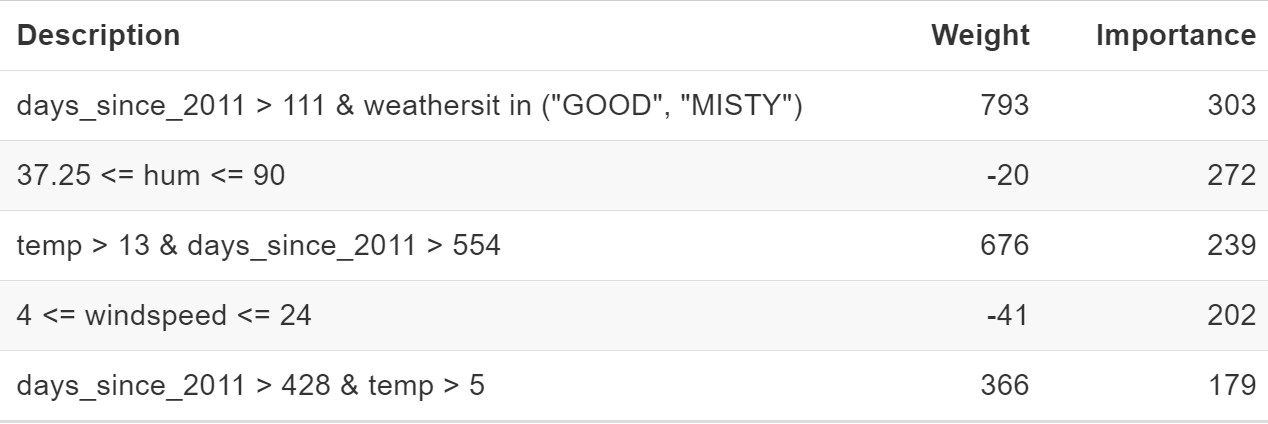

In [3]:
from IPython.display import Image
Image("rulefit example.PNG", height=400, width=400)

The most important rule was: "days_since_2011 > 111 & weathersit in ("GOOD", "MISTY")" and the corresponding weight is 793. The interpretation is: If days_since_2011 > 111 & weathersit in ("GOOD", "MISTY"), then the predicted number of the numeric outcome increases by 793, when all other feature values remain fixed. 

RuleFit automatically adds feature interactions to linear models. Therefore, it solves the problem of linear models that you have to add interaction terms manually; it also helps a bit with the issue of modeling nonlinear relationships. The algorithm can also handle both classification and regression tasks. In addition, the rules created are easy to interpret, because they are binary decision rules. Either the rule applies to an instance or not. Good interpretability is only guaranteed if the number of conditions within a rule is not too large. 

The end product of the RuleFit procedure is a linear model with additional fancy features (the decision rules). But since it is a linear model, the weight interpretation is still unintuitive. 

### III. Some Simple Examples of Model Agnostic Methods for Interpretability 

Separating the explanations from the machine learning model (a.k.a. model-agnostic interpretation methods) has some advantages (Ribeiro, Singh, and Guestrin 2016). The great advantage of model-agnostic interpretation methods over model-specific ones is their flexibility. Machine learning developers are free to use any machine learning model they like when the interpretation methods can be applied to any model. Anything that builds on an interpretation of a machine learning model, such as a graphic or user interface, also becomes independent of the underlying machine learning model. Typically, not just one, but many types of machine learning models are evaluated to solve a task, and when comparing models in terms of interpretability, it is easier to work with model-agnostic explanations, because the same method can be used for any type of model.

##### 1. Partial Dependence Plot (PDP)

The **partial dependence plot (PDP)** shows the marginal effect one or two features have on the predicted outcome of a machine learning model (J. H. Friedman 2001). A partial dependence plot can show whether the relationship between the target and a feature is linear, monotonic or more complex. For example, when applied to a linear regression model, partial dependence plots always show a linear relationship. 

Intuitively, we can interpret the partial dependence as the expected target response as a function of the input features of interest. Due to the limits of human perception the size of the set of input feature of interest must be small (usually, one or two) thus the input features of interest are usually chosen among the most important features.

The figure below shows two one-way and one two-way partial dependence plots for the California housing dataset after boosting (predicting housing prices using different attributes such as house ages, average occupancy etc.):

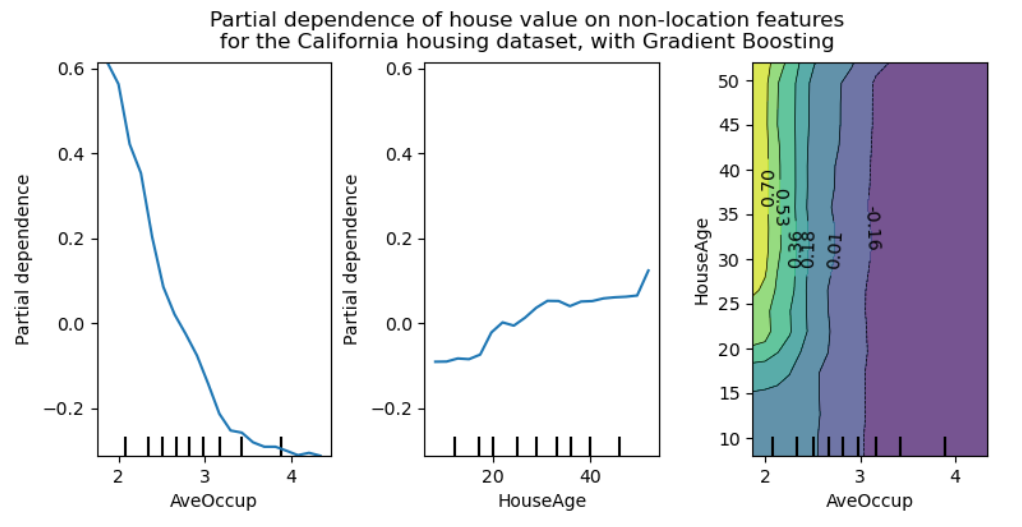

In [4]:
from IPython.display import Image
Image("PDP.PNG", height=400, width=400)

One-way PDPs tell us about the interaction between the target response and an input feature of interest feature (e.g. linear, non-linear). The left plot in the above figure shows the effect of the average occupancy on the median house price; we can clearly see a linear relationship among them when the average occupancy is inferior to 3 persons. Similarly, we could analyze the effect of the house age on the median house price (middle plot). Thus, these interpretations are marginal, considering a feature at a time.

PDPs with two input features of interest show the interactions among the two features. For example, the two-variable PDP in the above figure shows the dependence of median house price on joint values of house age and average occupants per household. We can clearly see an interaction between the two features: for an average occupancy greater than two, the house price is nearly independent of the house age, whereas for values less than 2 there is a strong dependence on age.

Below, we make a pseudo dataset and train it with gradient boosting. Then we create the partial dependence plot:

(12000, 10)
(12000,)
data type of X: <class 'numpy.ndarray'>
data type of y: <class 'numpy.ndarray'>


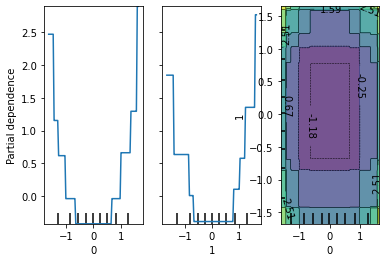

In [5]:
X, y = make_hastie_10_2(random_state=0) # y takes on values of 1 or -1 
print(X.shape)
print(y.shape)
print('data type of X:', type(X))
print('data type of y:', type(y))
gb_model=GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
clf = gb_model.fit(X, y)
features = [0, 1, (0, 1)] 
plot_partial_dependence(clf, X, features) 

For multi-class classification, you need to set the class label for which the PDPs should be created via the target argument:

(150, 4)
(150,)
data type of covariates: <class 'numpy.ndarray'>
data type of target variable: <class 'numpy.ndarray'>
unique value of target variable: [0 1 2]


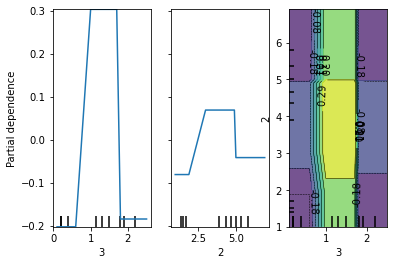

In [6]:
iris = load_iris()
print(iris.data.shape)
print(iris.target.shape)
print('data type of covariates:', type(iris.data))
print('data type of target variable:', type(iris.target))
print('unique value of target variable:', pd.DataFrame(iris.target, columns=['target']).target.unique())
gb_model_mc=GradientBoostingClassifier(n_estimators=10, max_depth=1) # multiclass training using gradient boosting
mc_clf = gb_model_mc.fit(iris.data, iris.target)
features = [3, 2, (3, 2)]
plot_partial_dependence(mc_clf, iris.data, features, target=1) 

Let $S$ be a set of features we are interested in and let $S^{C}$ be its complement (set of featueres we are not interested in); let $x \in S$ and $u \in S^{C}$ so that $S \cup S^{C}=W$ (complete feature space). Suppose we have a statistical learner $m(.)$ such that $y=m(w)+\epsilon$, $w=(x,u)$. The partial dependence function for a statistical learner is defined by marginalizing the machine learning model output over the distribution of the features in set $S^{C}$, so that the function shows the relationship between the features in set $S$ we are interested in and the predicted outcome. Mathematically, $PDP(x_{i}|x_{i} \in S)=\int m(x_{i}, u_{i})dPr(u_{i}|u_{i} \in S^{C})=\int m(x_{i}, u_{i})f_{u}(u_{i}|u_{i} \in S^{C})du_{i}=E_{S^{C}}(m(x_{i}, S^{C}))$ (expectation over $S^{C}$) where $f_{u}(.)$ is the marginal density (pdf) of $u$. The partial function is estimated by calculating averages in the training data, also known as Monte Carlo method: $\widehat{PDP}(x_{i}|x_{i} \in S)=\frac{1}{n}\sum_{i=1}^{n}m(x_{i}, u_{i}|u_{i} \in S^{C})$. The partial dependence function tells us for given value(s) of features S what the average marginal effect on the prediction is. In this formula, $u_{i}$'s are actual feature values from the dataset for the features in which we are not interested, and $n$ is the number of instances in the dataset. An assumption of the PDP is that the features in $S^{C}$ are not correlated with the features in $S$. If this assumption is violated, the averages calculated for the partial dependence plot will include data points that are very unlikely or even impossible.

For classification where the machine learning model outputs probabilities, the partial dependence plot displays the probability for a certain class given different values for feature(s) in $S$. An easy way to deal with multiple classes is to draw one line or plot per class.

The partial dependence plot is a global method: The method considers all instances and gives a statement about the global relationship of a feature with the predicted outcome. Meanwhile in practice, the set of features $S$ usually only contains one feature or a maximum of two, because one feature produces 2D plots and two features produce 3D plots. Everything beyond that is quite tricky. Even 3D on a 2D paper or monitor is already challenging.

For categorical features, the partial dependence is very easy to calculate. For each of the categories, we get a PDP estimate by forcing all data instances to have the same category. For example, if we look at a bike rental dataset, which contains daily counts of rented bicycles from the bicycle rental company Capital-Bikeshare in Washington D.C., along with weather and seasonal information, and are interested in the partial dependence plot for the variable 'season', we get 4 numbers, one for each season. To compute the value for the summer season, we replace the season of all data instances with "summer" and average the predictions.

Below is an example of using the rental bike dataset in which we predict the number of bikes that will be rented on a given day (a regression problem). First we fit a machine learning model, then we analyze the partial dependencies. In this case, suppose we have fitted a random forest model to predict the number of bicycles and use the partial dependence plot to visualize the relationships the model has learned. The influence of the weather features on the predicted bike counts is visualized in the following figure:

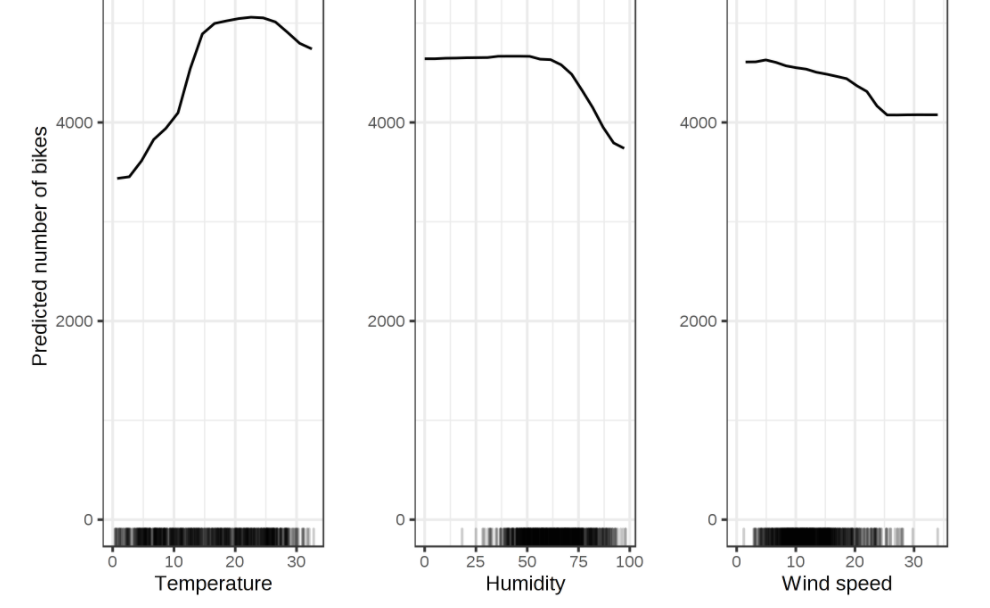

In [7]:
from IPython.display import Image
Image("PDP for rental bikes.PNG", height=400, width=400)

For warm but not too hot weather, the model predicts on average a high number of rented bicycles. Potential bikers are increasingly inhibited in renting a bike when humidity exceeds 60%. In addition, the more wind the fewer people like to cycle, which makes sense. Interestingly, the predicted number of bike rentals does not fall when wind speed increases from 25 to 35 km/h, but there is not much training data, so the machine learning model could probably not learn a meaningful prediction for this range. 

To illustrate a partial dependence plot with a categorical feature, we examine the effect of the season feature on the predicted bike rentals:

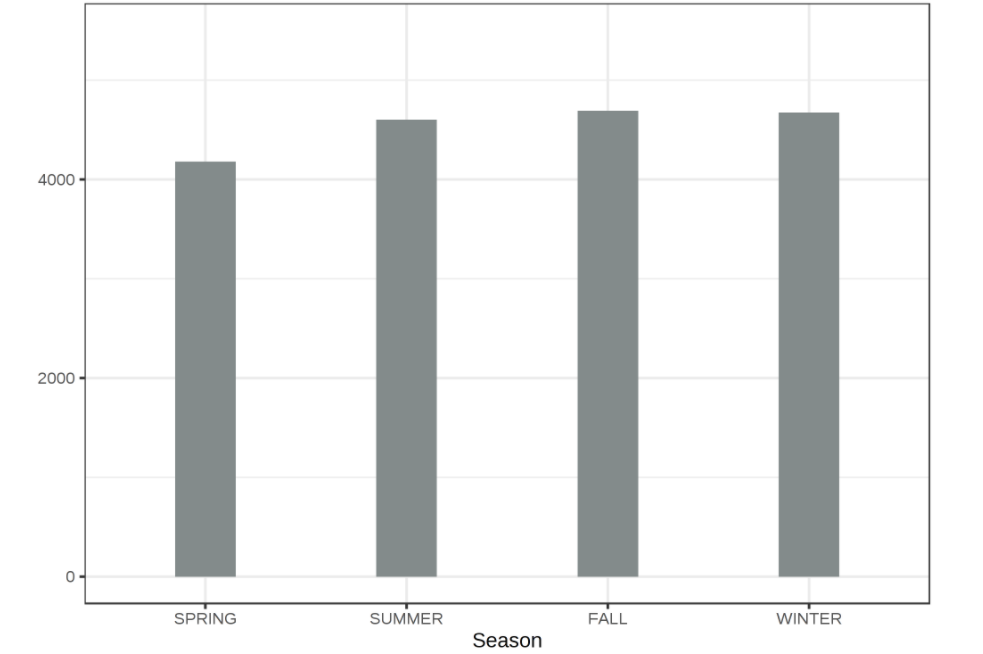

In [8]:
from IPython.display import Image
Image("PDP for categorical.PNG", height=400, width=400)

PDP certainly has its merits and disadvantages. The computation of partial dependence plots is intuitive: the partial dependence function at a particular feature value represents the average prediction if we force all data points to assume that feature value. If the feature for which we computed the PDP is not correlated with the other features, then the PDPs perfectly represent how the feature influences the prediction on average. In the uncorrelated case, the interpretation is clear: the PDP shows how the average prediction in the dataset changes when the $k$-th feature is changed. To some extent, the calculation for the partial dependence plots has a causal interpretation. We intervene on a feature and measure the changes in the predictions. In doing so, we analyze the causal relationship between the feature and the prediction. The relationship is causal for the model because we explicitly model the outcome as a function of the features, see the discussion in Zhao and Hastie (2019).

PDP is certainly not perfect. For example, the realistic maximum number of features in a partial dependence function is 2. This is not the fault of PDPs, but of the 2-dimensional representation and also of our inability to imagine more than 3 dimensions. In addition, some PDPs do not show the feature distribution. Omitting the distribution can be misleading, because we might over-interpret regions with almost no data. This problem is easily solved by showing a rug (indicators for data points on the x-axis) or a histogram.

The assumption of independence is the biggest issue with PDP. It is assumed that the feature(s) for which the partial dependence is computed are not correlated with other features. For example, suppose we want to predict how fast a person walks, given the person's weight and height. For the partial dependence of one of the features, e.g. height, we assume that the other features (weight) are not correlated with height, which is obviously a false assumption. For the computation of the PDP at a certain height (say 200 cm), we average over the marginal distribution of weight, which might include a weight below 50 kg, which is unrealistic for a 2-meter tall person. In other words, when the features are correlated, we create new data points in areas of the feature distribution where the actual probability is very low. 

Heterogeneous effects might be hidden because PDP only show the average marginal effects. Suppose that for a feature, half the data points have a positive association with the prediction; the larger the feature value the larger the prediction. The other half has a negative association; the smaller the feature value the larger the prediction. The PDP curve could be a horizontal line, since the effects of both halves of the dataset could cancel each other out. We then conclude that the feature has no effect on the prediction, and obviously, this is a misleading conclusion. 

##### 2. Individual Conditional Expectation (ICE)

Individual Conditional Expectation (ICE) plots display one line per instance that shows how the instance's prediction changes when a feature changes.

The partial dependence plot for the average effect of a feature is a global method because it does not focus on specific instances, but on an overall average. The equivalent to a PDP for individual data instances is called individual conditional expectation (ICE) plot (Goldstein et al. 2017). An ICE plot visualizes the dependence of the prediction on a feature for each instance separately, resulting in one line per instance, compared to one line overall in partial dependence plots. A PDP is the average of the lines of an ICE plot. The values for a line (and one instance) can be computed by keeping all other features the same, creating variants of this instance by replacing the feature's value with values from a grid and making predictions with the black box model for these newly created instances. The result is a set of points for an instance with the feature value from the grid and the respective predictions.

Recall that partial dependence plots can obscure a heterogeneous relationship created by interactions. PDPs can show us what the average relationship between a feature and the prediction looks like. This only works well if the interactions between the features for which the PDP is calculated and the other features are weak. In case of interactions, the ICE plot will provide much more insight.

Let's use the bike rental dataset again to illustrate what ICE looks like:

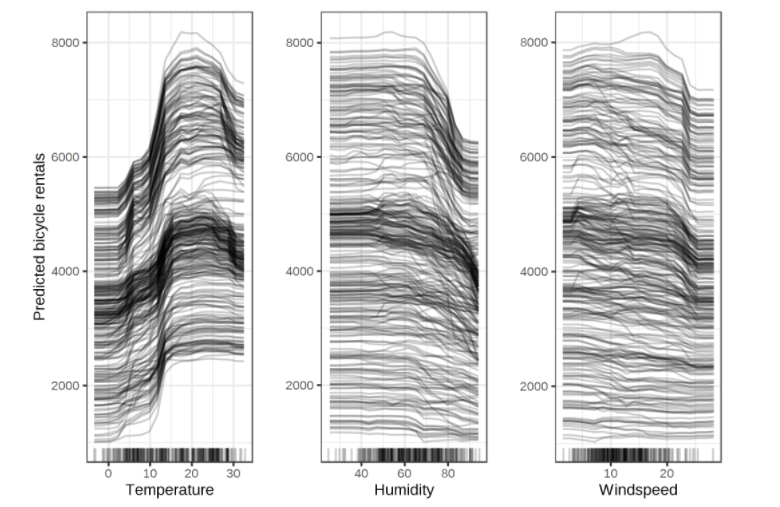

In [9]:
from IPython.display import Image
Image("ICE for rental bikes.PNG", height=400, width=400)

Like what we did before using the pseudo dataset, we can train it with gradient boosting. Then we create the ICE plot. The 'sklearn.inspection' module’s plot_partial_dependence() convenience function can be used to create ICE plots by setting the argument _kind='individual'_. In fact, PDP and ICE usually can be placed together by setting the argument to be _kind='both'_. Below are the commands:

   - plot_partial_dependence(clf, X, features, kind='individual') 
   - plot_partial_dependence(clf, X, features, kind='both') 

ICE certainly has its strength and weaknesses as well. Individual conditional expectation curves are even more intuitive to understand than partial dependence plots. One line represents the predictions for one instance if we vary the feature of interest. Thus, unlike partial dependence plots, ICE curves can uncover heterogeneous relationships.

ICE has two main weaknesses. First, ICE curves can only display one feature meaningfully, because two features would require the drawing of several overlaying surfaces and you would not see anything in the plot. Second, ICE curves suffer from the same problem as PDPs: If the feature of interest is correlated with the other features, then some points in the lines might be invalid data points according to the joint feature distribution.

##### 3. Accumulated Local Effects (ALE) Plot 

Partial dependence plots (PDP) and individual conditional expectations (ICE), both of which are popular approaches for visualizing the effects of the predictors with black box supervised learning models, can produce erroneous results if the predictors are strongly correlated, because they require extrapolation of the response at predictor values that are far outside the multivariate envelope of the training data. This is where the accumulated local effects (ALE) plots can kick in. ALE plots do not require extrapolation; and like PDP, they are not biased by the omitted variable phenomenon. Moreover, ALE plots are far less computationally expensive than PD plots. In this section we follow the notation of the original paper by Apley and Zhu (2016) to discuss the construction of ALE and its applications. 

Let's motivate the discussion of ALE from the basic setup of PDP. Let $S$ be a set of features we are interested in and let $S^{C}$ be its complement (set of featueres we are not interested in); Let $x \in S$ and $z \in S^{C}$ so that $S \cup S^{C}=W$ (complete feature space). Suppose we have a statistical learner $m(.)$ such that $y=m(w)+\epsilon$, $w=(x,u)$. The partial dependence function for a statistical learner is defined by marginalizing the machine learning model output over the distribution of the features in set $S^{C}$, so that the function shows the relationship between the features in set $S$ we are interested in and the predicted outcome. Mathematically:

   - $PDP(x_{i}|x_{i} \in S)=\int m(x_{i}, u_{i})f_{u}(u_{i})du_{i}=E_{S^{C}}(m(x_{i}, u_{i}))$.
   
The expectation over $S^{C}$, and $f_{u}(.)$ is the marginal density (pdf) of $u$. The partial function is estimated by calculating averages in the training data, also known as Monte Carlo method: 
   
   - $\widehat{PDP}(x_{i}|x_{i} \in S)=\frac{1}{n}\sum_{i=1}^{n}m(x_{i}, u_{i})$.

The partial dependence function tells us for given value(s) of features S what the average marginal effect on the prediction is. In this formula, $u_{i}$'s are actual feature values from the dataset for the features in which we are not interested, and $n$ is the number of instances in the dataset. An assumption of the PDP is that the features in $S^{C}$ are not correlated with the features in $S$. If this assumption is violated, the averages calculated for the partial dependence plot will include data points that are very unlikely or even impossible.

Our objective is to visualize and understand the main effect of dependence of $m(w)$ on each of the individual predictors, as well as the low-order interaction effects among pairs of predictors. Throughout the introduction we illustrate concepts for the
simple 2-dimensional case so that $w=(x,u) \in \mathbb{R}^{2}$. One thing that we could possibly tweak on the PDP picture is by using something called **M-plot** (MP, with M stands for marginal). In PDP, the marginal density $f_{u}(u)$ is much less concentrated around the data than the conditional density $f_{u|x}(u|x)$, due to the strong dependence between $u$ and $x$. So M-plot tries to solve this problem by using the conditional density in place of the marginal density. An M-plot of the effect of $x$ is a plot of the function:

   - $MP(x_{i}|x_{i} \in S)=\int m(x_{i}, u_{i})f_{u|x}(u_{i}|x_{i})du_{i}=E_{S^{C}}(m(x_{i}, u_{i})|x_{i})$ 
   
The expectation is, again, over $S^{C}$. A Monte Carlo estimate is:

   - $\widehat{MP}(x_{i}|x_{i} \in S)=\frac{1}{n(x)}\sum_{i \in N(x)}m(x_{i}, u_{i})$.
   
Here, $N(x)$ is a subset of $\{1,2,3,...n\}$. It is a subset of the row indices $i$ for which $x_{i}$ falls into some small appropriately selected neighborhood of $x$; and $n(x)$ is the number of observations in that neighborhood. Although sophisticated methods exist for estimation of MP, we do not consider them here. Because this formulation is problematic in the sense that if the response variable depends on both $x$ and $u$, the MP plot will reflect both of their effects, a consequence of the omitted variable bias phenomenon in regression. Namely, using the M-plot is like regressing $y$ onto $x$ while ignoring (marginalizing over) the nuisance variable $u$. So this motivated the discussion of **accumulated local effect (ALE)**. For the case $K=2$ so that $w=(x,u) \in \mathbb{R}^{K=2}$ with our model $y=m(w) + \epsilon$. If $m(..)$ is differentiable, then we can define the (uncentered) ALE main-effect of $x$ as the following:

   - $UALE(x_{i}|x_{i} \in S)=\int_{\underline{x}}^{x}E(\frac{\partial m(x_{i}, u_{i})}{\partial x_{i}}|x_{i})dx_{i}-c = \int_{\underline{x}}^{x}\int f_{u|x}(u_{i}|x_{i})\frac{\partial m(x_{i}, u_{i})}{\partial x_{i}}du_{i}dx_{i}-c$. 
   
Here $\underline{x}$ is some value chosen near the lower bound of the effective support of the marginal $f_{x}(.)$, e.g., just below the smallest observation $\min{x_{i}}$ and the partial derivative represents the local effect of $x$ on $m(..)$. The choice of the lower bar $\underline{x}$ is not that important, as it only affects the vertical translation of the ALE plot, and the constant $c$ will be chosen to vertically center the plot. 

The formula of ALE above in the simple 2-dimensional case reveals three differences to M-Plots. First, we average the changes of predictions, not the predictions itself. The change is defined as the gradient (but later, for the actual computation, replaced by the differences in the predictions over an interval). The second difference is the additional integral over $x$. We accumulate the local gradients over the range of features in set $S$, which gives us the effect of the feature on the prediction. For the actual computation, the $x$'s are replaced by a grid of intervals over which we compute the changes in the prediction. Instead of directly averaging the predictions, the ALE method calculates the prediction differences conditional on features $S$ and integrates the derivative over features $S$ to estimate the effect. Well, that sounds stupid. Derivation and integration usually cancel each other out. Why does it make sense here? The key is to realize that the derivative (or interval difference) isolates the effect of the feature of interest and blocks the effect of correlated features. The third difference of ALE plots to M-plots is that we subtract a constant from the results. This step centers the ALE plot so that the average effect over the data is zero.

The rest of the problem centers on how we can estimate ALE, because at the end of the day. not all models come with a gradient (e.g. random forests). The actual way people implement ALE is through its discrete version (using small intervals), which is explained in the original paper by Apley and Zhu (2016). Here we will briefly touch on the idea and then explain the usage of the method from a more applied perspective. 

In this section, we will define the (general version of) ALE main effect functions for each predictor. ALE plots are plots of estimates of these functions. Because of the notational complexity, we will redefine our mathematical notations here. Suppose we have a machine learning model $y=m(x)+\epsilon$ with $x \in \mathbb{R}^{K}$. Suppose $x$ has a joint distribution with a compact support and the support of $Pr(x_{k})$ is the interval $\mathscr{S}_{k}=[\underline{x}_{k}, \overline{x}_{k}]$ for each $k=1,2,...K$. Now, for each $D=1,2,...$ and $k=1,2,...K$, let $\mathscr{P}_{k}^{D}=\{z_{d,k}^{D}: d=0,1,...D\}$ be a partition of $\mathscr{S}_{k}$ into $D$ intervals with $z_{0,k}^{D}=\underline{x}_{k}$ and $z_{D,k}^{D}=\overline{x}_{k}$ (the superscript indicates the number of intervals).

Define $\delta_{k, D}=max\{|z_{d,k}^{D} - z_{d-1,k}^{D}|: d=1,2,...D\}$ which represents the fineness of the partition. For any $x \in \mathscr{S}_{k}$, define $d_{k}^{D}(x)$ to be the index of the interval $\mathscr{P}_{k}^{D}$ into which $x$ falls, i.e., $x \in (z_{d-1,k}^{D}, z_{d,k}^{D}]$ for $d=d_{k}^{D}(x)$. Now let's define $x_{-k}$ to be the subset of the $K-1$ predictors excluding $x_{k}$. The following definition is the generalization of the uncentered ALE main effect:

##### Definition:

Using the notations above, suppose the sequence of partitions $\mathscr{P}_{k}^{D}=\{z_{d,k}^{D}: d=0,1,...D\}$ satisfies the following condition: $\lim_{D \rightarrow \infty} \delta_{k, D}=0$. When $m(.)$ and the distribution of $x$ are such that the following limit exists and is independent of the particular sequence of partitions (See Appendix A in Zhu and Apley 2016), we define the uncentered ALE main (i.e. first-order) effect function of $x_{k} \in \mathscr{S}_{k}$ as the following:

   - $UALE(x_{k})=\lim_{D \rightarrow \infty}\sum_{d=1}^{d_{k}^{D}(x_{k})}E[m(z_{d,k}^{D}, x_{-k}) - m(z_{d-1,k}^{D}, x_{-k})|x_{k} \in (z_{d-1,k}^{D}, z_{d,k}^{D}]]$.
   
The centered ALE (ALE) is then defined as $ALE(x_{k})=UALE(x_{k}) - \int f_{k}(z_{k})UALE(z_{k})dz_{k}$, which has a mean 0.

In a similar fashion, the second order effect function can also be defined (using double integrals). Due to notational complexity, we will avoid the details here for now. But Zhu and Apley (2016) in their paper basically showed that the UALE (uncentered ALE) is equivalent to the equation before and explained the intuition. 

They also laid out the estimation technique in Section 3 of the paper for both 1st order and 2nd order effect. 

First I will describe how ALE plots are estimated for a single numerical feature, later for two numerical features and for a single categorical feature. To estimate local effects, we divide the feature into many intervals and compute the differences in the predictions. This procedure approximates the gradients and also works for models without gradients. To estimate the main effect function of a predictor $x_{k}$, we first compute an estimate of the uncentered effect, which is:

   - $\widehat{UALE(x)}=\sum_{d=1}^{d_{k}(x)}\frac{1}{n_{k}(d)}\sum_{i:x_{ik} \in N_{k}(d)}[m(z_{d,k}, x_{i,-k}) - m(z_{d-1,k}, x_{i,-k})]$ for $ \forall x \in (z_{0,k}, z_{D,k}]$.
   
Analogously, the ALE main effect estimator can be defined as the following:

   - $\widehat{ALE(x)}=\widehat{UALE(x)} - \frac{1}{n}\sum_{d=1}^{D}n_{k}(d)\widehat{UALE(z_{d,k})}$. 

Let us break this formula down, starting from the right side. The name **accumulated local effects** nicely reflects all the individual components of this formula.  At its core, the ALE method calculates the differences in predictions, whereby we replace the feature of interest with grid values $z$. The difference in prediction is the effect the feature has for an individual instance in a certain interval. The sum on the right adds up the effects of all instances within an interval which appears in the formula as neighborhood $N_{k}(d)$. We divide this sum by the number of instances in this interval to obtain the average difference of the predictions for this interval. This average in the interval is covered by the term 'local' in the name ALE. The left sum symbol means that we accumulate the average effects across all intervals. The (uncentered) ALE of a feature value that lies, for example, in the third interval is the sum of the effects of the first, second and third intervals.

The value of the ALE can be interpreted as the main effect of the feature at a certain value compared to the average prediction of the data. For example, an ALE estimate of -2 at $x_{k}=3$ means that when the $k$-th feature has value 3, then the prediction is lower by 2 compared to the average prediction.

The quantiles of the distribution of the feature are used as the grid that defines the intervals. Using the quantiles ensures that there is the same number of data instances in each of the intervals. Quantiles have the disadvantage that the intervals can have very different lengths. This can lead to some weird ALE plots if the feature of interest is very skewed, for example many low values and only a few very high values.

ALE plots can also show the interaction effect of two features. The calculation principles are the same as for a single feature, but we work with rectangular cells instead of intervals, because we have to accumulate the effects in two dimensions. In addition to adjusting for the overall mean effect, we also adjust for the main effects of both features. This means that ALE for two features estimate the second-order effect, which does not include the main effects of the features. In other words, ALE for two features only shows the additional interaction effect of the two features. We will ignore the notations for the second-order effect as it's long and unpleasant to display (see the original paper, formulas (13) - (16)). Here we will rely on visualizations to develop intuition about the second-order ALE calculation.

Since the ALE estimates for two features only show the second-order effect of the features, the interpretation requires special attention. The second-order effect is the additional interaction effect of the features after we have accounted for the main effects of the features. Suppose two features do not interact, but each has a linear effect on the predicted outcome. In the 1D ALE plot for each feature, we would see a straight line as the estimated ALE curve. But when we plot the 2D ALE estimates, they should be close to zero, because the second-order effect is only the additional effect of the interaction. ALE plots and PD plots differ in this regard: PDPs always show the total effect, ALE plots show the first- or second-order effect. These are design decisions that do not depend on the underlying math. You can subtract the lower-order effects in a partial dependence plot to get the pure main or second-order effects or, you can get an estimate of the total ALE plots by refraining from subtracting the lower-order effects. The accumulated local effects could also be calculated for arbitrarily higher orders (interactions of three or more features), but the interpretation becomes tricky and confusing, so most of the times we only care about interpretations up to 2 features.

Below is a picture of the second-order ALE calculation. We place a grid over the two features. In each grid cell we calculate the 2nd-order differences for all instance within. We first replace values of $x_{1}$ and $x_{2}$ with the values from the cell corners. If $a, b, c$ and $d$ represent the "corner"-predictions of a manipulated instance (as labeled in the graphic), then the 2nd-order difference is $(d-c)-(b-a)$. The mean 2nd-order difference in each cell is accumulated over the grid and centered. In addition, many cells are empty due to the correlation. In the ALE plot this can be visualized with a grayed out or darkened box. Alternatively, you can replace the missing ALE estimate of an empty cell with the ALE estimate of the nearest non-empty cell.

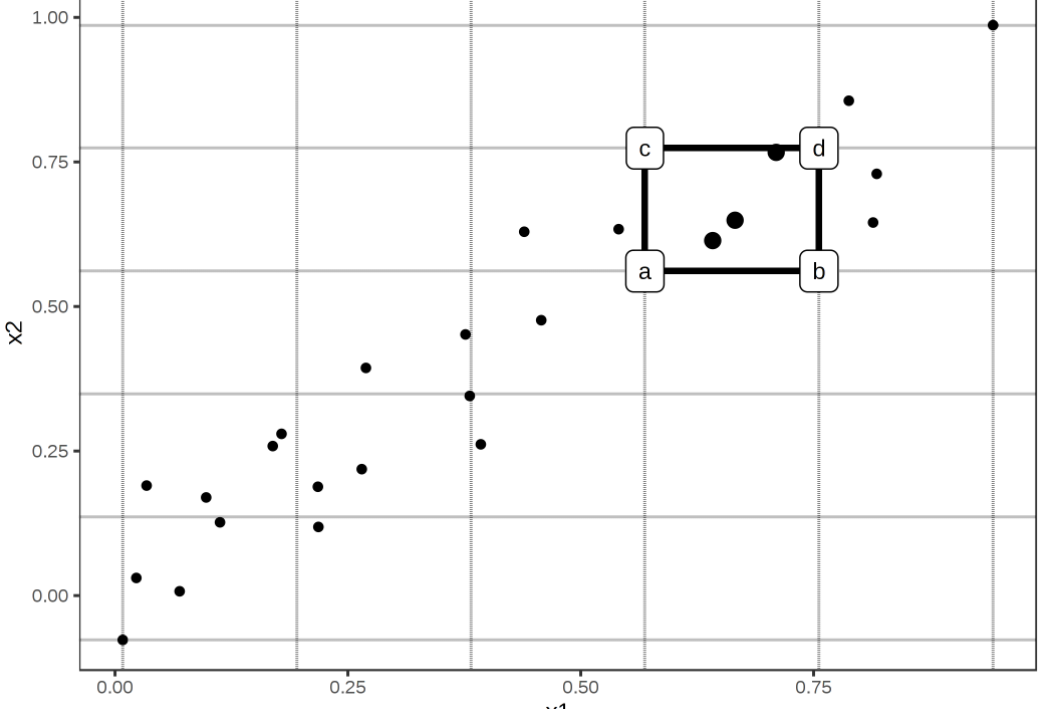

In [10]:
from IPython.display import Image
Image("second order ALE.PNG", height=400, width=400)

The accumulated local effects method needs -- by definition -- the feature values to have an order, because the method accumulates effects in a certain direction. Categorical features do not have any natural order. To compute an ALE plot for a categorical feature we have to somehow create or find an order. The order of the categories influences the calculation and interpretation of the accumulated local effects.

One solution is to order the categories according to their similarity based on the other features. The distance between two categories is the sum over the distances of each feature. The feature-wise distance compares either the cumulative distribution in both categories, also called Kolmogorov-Smirnov distance (for numerical features) or the relative frequency tables (for categorical features). Once we have the distances between all categories, we use multi-dimensional scaling to reduce the distance matrix to a one-dimensional distance measure. This gives us a similarity-based order of the categories.

To make this a little bit clearer, here is one example: Let us assume we have the two categorical features "season" and "weather" and a numerical feature "temperature". For the first categorical feature (season) we want to calculate the ALEs. The feature has the categories "spring", "summer", "fall", "winter". We start to calculate the distance between categories "spring" and "summer". The distance is the sum of distances over the features temperature and weather. For the temperature, we take all instances with season "spring", calculate the empirical cumulative distribution function and do the same for instances with season "summer" and measure their distance with the Kolmogorov-Smirnov statistic. For the weather feature we calculate for all "spring" instances the probabilities for each weather type, do the same for the "summer" instances and sum up the absolute distances in the probability distribution. If "spring" and "summer" have very different temperatures and weather, the total category-distance is large. We repeat the procedure with the other seasonal pairs and reduce the resulting distance matrix to a single dimension by multi-dimensional scaling (MDS).

Let us see ALE plots in action. Let's construct a scenario in which partial dependence plots fail. The scenario consists of a prediction model and two strongly correlated features. The prediction model is mostly a linear regression model, but does something weird at a combination of the two features for which we have never observed instances. Below, we show two features and the predicted outcome. The model predicts the sum of the two features (shaded background), with the exception that if $x_{1}$ is greater than 0.7 and $x_{2}$ less than 0.3, the model always predicts 2. This area is far from the distribution of data (point cloud) and does not affect the performance of the model and also should not affect its interpretation:

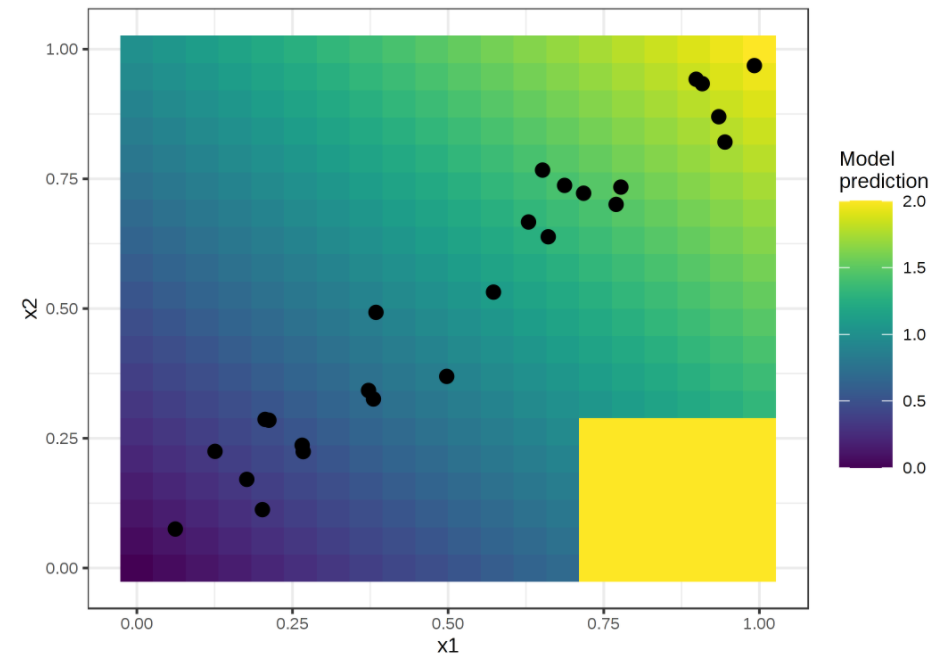

In [11]:
from IPython.display import Image
Image("PDP fail.PNG", height=400, width=400)

Is this a realistic, relevant scenario at all? When we train a model, the learning algorithm minimizes the loss for the existing training data instances. Weird stuff can happen outside the distribution of training data, because the model is not penalized for doing weird stuff in these areas. Leaving the data distribution is called **extrapolation**, which can also be used to fool machine learning models. Let's see in our little example how the partial dependence plots behave compared to ALE plots below. As the pictures show, the PDP estimates are influenced by the odd behavior of the model outside the data distribution (steep jumps in the plots), whereas the ALE plots correctly identify that the machine learning model has a linear relationship between features and prediction, ignoring areas without data.

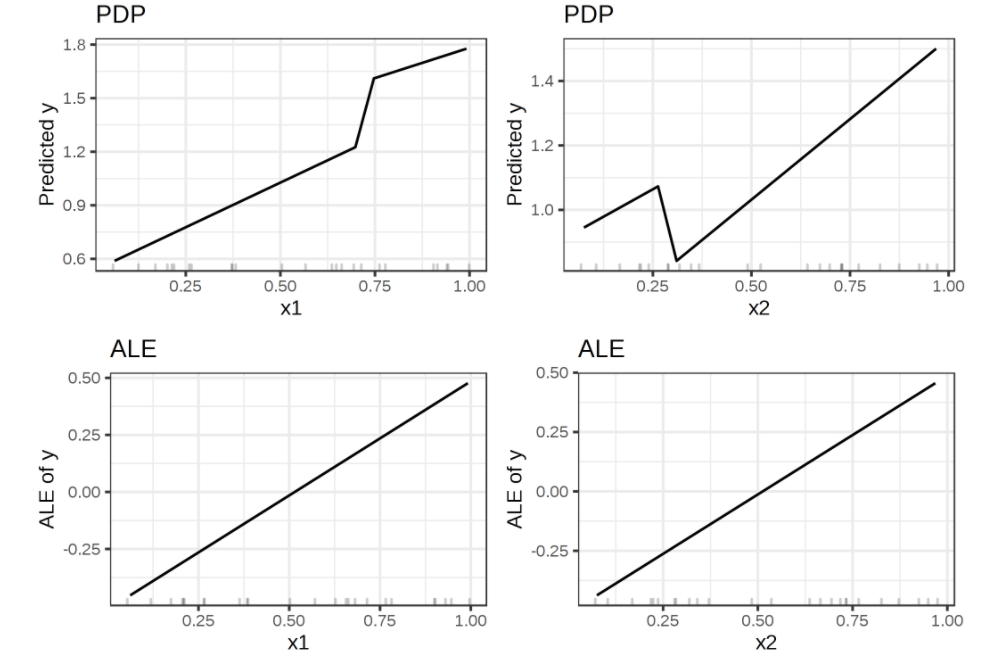

In [12]:
Image("ALE vs PDP.PNG", height=400, width=400)

Let's see some real code example. As of June 2021, the best Python package for ALE is the 'PyALE' package. The package offers the possibility to compute and plot the effect of one numeric feature (1D ALE); in addition, it can also compute and plot the effect of two numeric features (2D ALE). 

Since python models work with numeric features only, categorical variables are often encoded by one of two methods, either with integer encoding (when the categories have a natural ordering of some sort (e.g., days of the week) or with one-hot-encoding (when the categories do not have ordering, say colors). We will offer examples for both scenarios. The package offers the option to compute and plot the effect of such features, including the option to compute a confidence interval of the effect. In this case the use has two options:

   1. For integer encoding: the user can plot the effect of the feature as a discrete feature (and this does not require additional preparation steps).
   2. For one-hot-encoding (or any other custom encoding): the package, starting from version 1.1, offers the possibility to pass a custom encoding function to categorical (or string) features. In this case, the user must provide:
   
      - a function that encodes the raw feature;
      - a dataset that includes the raw feature instead of the encoded one (including all other features used for training);
      - a list of all predictors used for training the model;

The package by default uses the ordering assigned to the given categorical feature, however, if the feature does not have an assigned ordering, then the categories of the feature will be ordered by their similarities based on the distribution of the other features in each category.

Let's use the raw diamond dataset and later apply random forests to use the diamonds' information to predict diamonds' prices:

In [13]:
dat_diamonds = pd.read_csv("https://raw.githubusercontent.com/tidyverse/ggplot2/master/data-raw/diamonds.csv")
dat_diamonds.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [14]:
X_raw = dat_diamonds.loc[:, ~dat_diamonds.columns.str.contains("price")].copy() # keep everything except the 'price' column
y = dat_diamonds.loc[:, "price"].copy()
print(type(X_raw))
X_raw.info()

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    53940 non-null  float64
 1   cut      53940 non-null  object 
 2   color    53940 non-null  object 
 3   clarity  53940 non-null  object 
 4   depth    53940 non-null  float64
 5   table    53940 non-null  float64
 6   x        53940 non-null  float64
 7   y        53940 non-null  float64
 8   z        53940 non-null  float64
dtypes: float64(6), object(3)
memory usage: 3.7+ MB


Now let's look at the non-numeric features:

In [15]:
def vfreq(dsn, var):
    print(dsn[var].value_counts(), "\n")
    
vfreq(X_raw, 'color')
vfreq(X_raw, 'cut')
vfreq(X_raw, 'clarity')

G    11292
E     9797
F     9542
H     8304
D     6775
I     5422
J     2808
Name: color, dtype: int64 

Ideal        21551
Premium      13791
Very Good    12082
Good          4906
Fair          1610
Name: cut, dtype: int64 

SI1     13065
VS2     12258
SI2      9194
VS1      8171
VVS2     5066
VVS1     3655
IF       1790
I1        741
Name: clarity, dtype: int64 



Notice that the columns 'cut', 'color' and 'clarity' are categorical variables. So we will apply both techniques of plotting categorical variables. For integer coding, we need to 'order' them in some way to apply ALE. We will leave the variable 'color' out for now (for one-hot encoding example later): 

In [16]:
X = X_raw.copy()

X.loc[:, "cut"] = X.loc[:, "cut"].astype(pd.api.types.CategoricalDtype(
    categories=["Fair", "Good", "Very Good", "Premium", "Ideal"], ordered=True)
                                        ) # converting the three text columns to ordered categoricals
X.loc[:, "clarity"] = X.loc[:, "clarity"].astype(pd.api.types.CategoricalDtype(
    categories=["I1", "SI2", "SI1", "VS2", "VS1", "VVS2", "VVS1", "IF"],ordered=True)
                                                )

X.loc[:, "cut_code"] = X.loc[:, "cut"].cat.codes # using the codes of each categorical as a numeric encoding for the feature
X.loc[:, "clarity_code"] = X.loc[:, "clarity"].cat.codes

X.head(7)

,carat,cut,color,clarity,depth,table,x,y,z,cut_code,clarity_code
0,0.23,Ideal,E,SI2,61.5,55.0,3.95,3.98,2.43,4,1
1,0.21,Premium,E,SI1,59.8,61.0,3.89,3.84,2.31,3,2
2,0.23,Good,E,VS1,56.9,65.0,4.05,4.07,2.31,1,4
3,0.29,Premium,I,VS2,62.4,58.0,4.20,4.23,2.63,3,3
4,0.31,Good,J,SI2,63.3,58.0,4.34,4.35,2.75,1,1
5,0.24,Very Good,J,VVS2,62.8,57.0,3.94,3.96,2.48,2,5
6,0.24,Very Good,I,VVS1,62.3,57.0,3.95,3.98,2.47,2,6


In [17]:
one_hot_encoder = OneHotEncoder(drop=None).fit(X[["color"]]) # fitting a one-hot-encoder with all possible categories in the feature
print(type(one_hot_encoder))

def onehot_encode_f(feat, ohe=one_hot_encoder): # 'feat' here stands for 'feature'
    col_names = ohe.categories_[0]
    feat_coded = pd.DataFrame(ohe.transform(feat).toarray())
    feat_coded.columns = col_names
    return feat_coded

coded_feature = onehot_encode_f(X[["color"]])
X = pd.concat([X, coded_feature], axis=1) # appending the encoded dummy variabe in the dataset
X = X.loc[:,~X.columns.duplicated()] # removing duplicated columns if any
X.columns

<class 'sklearn.preprocessing._encoders.OneHotEncoder'>


Index(['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'x', 'y', 'z',
       'cut_code', 'clarity_code', 'D', 'E', 'F', 'G', 'H', 'I', 'J'],
      dtype='object')

Now let's clean this up:

In [26]:
features_l = ["carat", "cut_code", "clarity_code", "depth", "table", "x", "y", "z"]
features_l = features_l + coded_feature.columns.to_list()
print("All the features to be used for ALE (notice that 'cut_code' and 'clarity_code' are integer-coding and all those 'D', 'E' etc. are one-hot encoding): ", features_l)

All the features to be used for ALE (notice that 'cut_code' and 'clarity_code' are integer-coding and all those 'D', 'E' etc. are one-hot encoding):  ['carat', 'cut_code', 'clarity_code', 'depth', 'table', 'x', 'y', 'z', 'D', 'E', 'F', 'G', 'H', 'I', 'J']


Now let's fix a random forests model and then evaluate its performance. For simplicity, since we are interested in the interpretation, we will skip the step of train-test split. We fit the model using the whole dataset for the purpose of this exercise, and then we will look at their performance and plot the $\hat{y}$ against $y$:

In [19]:
model = RandomForestRegressor(random_state=1345)
model.fit(X[features_l], y)

RandomForestRegressor(random_state=1345)

Mean Absolute Error (MAE): 98.20343246618818
Mean Squared Error (MSE): 40515.37918540823


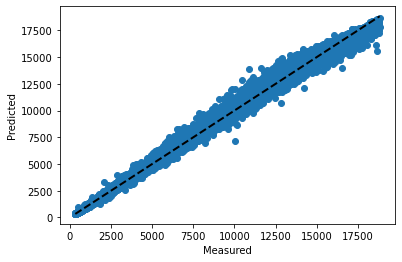

In [20]:
y_pred = model.predict(X[features_l])
print('Mean Absolute Error (MAE):', sk.metrics.mean_absolute_error(y, y_pred))
print('Mean Squared Error (MSE):', sk.metrics.mean_squared_error(y, y_pred))

fig, ax = plt.subplots()
ax.scatter(y, y_pred)
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

This is a regression problem, and thus by the picture above our model fit looks pretty reasaonble. Now let's do an ALE analysis. First, let's look at a first-order ALE (main effect) plot on "carat":

PyALE._ALE_generic:INFO: Continuous feature detected.


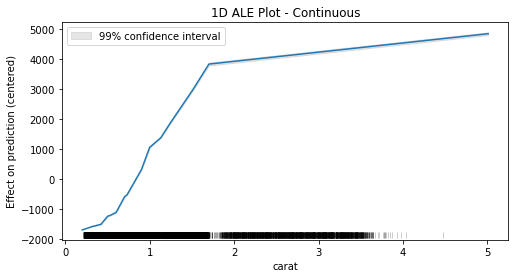

In [21]:
ale_eff = ale(X=X[features_l], model=model, 
              feature=["carat"], grid_size=20,
              include_CI=True, C=0.99) # include_CI dictates whether to draw the confidence interval

In [22]:
print(ale_eff)

               eff    size  lowerCI_99%  upperCI_99%
carat                                               
0.20  -1702.300108     0.0          NaN          NaN
0.30  -1606.997267  4203.0 -1611.488051 -1602.506484
0.31  -1595.765232  2249.0 -1596.856961 -1594.673504
0.32  -1584.587071  1840.0 -1585.437520 -1583.736623
0.35  -1568.540364  2766.0 -1569.544183 -1567.536545
0.40  -1529.264796  3333.0 -1530.960844 -1527.568748
0.42  -1515.881551  2088.0 -1518.157206 -1513.605895
0.50  -1245.565460  2453.0 -1251.696936 -1239.433983
0.53  -1217.885210  2653.0 -1220.556378 -1215.214043
0.60  -1118.648065  2863.0 -1122.843770 -1114.452359
0.70   -599.326780  2714.0  -610.149019  -588.504542
0.73   -531.483603  2550.0  -536.649503  -526.317703
0.90    305.126085  3890.0   292.025860   318.226310
1.00   1065.131662  2836.0  1032.299445  1097.963879
1.01   1075.135832  2242.0  1070.408333  1079.863332
1.04   1150.249810  1881.0  1139.511437  1160.988183
1.13   1369.314699  2692.0  1355.491917  1383.

Now let's look at a discrete variable (it has its order assigned):

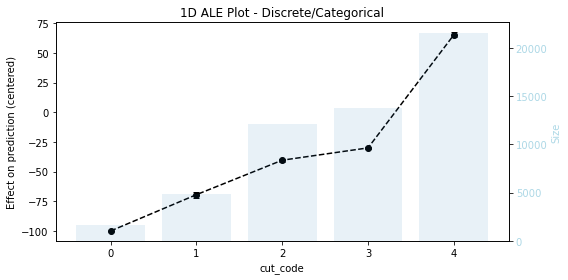

In [23]:
ale_discr = ale(X=X[features_l], model=model, feature=["cut_code"], feature_type="discrete", include_CI=True, C=0.95)

Now let's look at the second method (one-hot encoding):

In [29]:
X_feat_raw = X.drop(coded_feature.columns.to_list(), axis=1, inplace=False).copy()
X_feat_raw.head()

,carat,cut,color,clarity,depth,table,x,y,z,cut_code,clarity_code
0,0.23,Ideal,E,SI2,61.5,55.0,3.95,3.98,2.43,4,1
1,0.21,Premium,E,SI1,59.8,61.0,3.89,3.84,2.31,3,2
2,0.23,Good,E,VS1,56.9,65.0,4.05,4.07,2.31,1,4
3,0.29,Premium,I,VS2,62.4,58.0,4.20,4.23,2.63,3,3
4,0.31,Good,J,SI2,63.3,58.0,4.34,4.35,2.75,1,1


PyALE._ALE_generic:INFO: categorical feature detected.


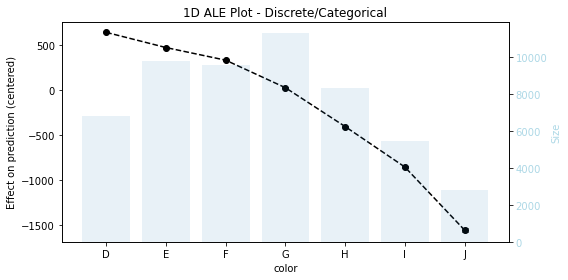

In [30]:
ale_eff = ale(X=X_feat_raw, model=model, feature=["color"], encode_fun=onehot_encode_f, predictors=features_l)

Now let's do a 2D plot (second-order effect):

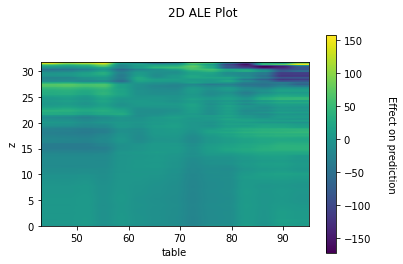

In [24]:
ale_eff = ale(X=X[features_l], model=model, feature=["z", "table"], grid_size=100)

### References: 

#### Interpretable AI:
   - https://christophm.github.io/interpretable-ml-book/
   - Doshi-Velez, Finale, and Been Kim. "Towards a rigorous science of interpretable machine learning," no. Ml: 1–13. http://arxiv.org/abs/1702.08608 (2017).
   - Robnik-Sikonja, Marko, and Marko Bohanec. "Perturbation-based explanations of prediction models." Human and Machine Learning. Springer, Cham. 159-175. (2018).
   - Friedman, Jerome H, and Bogdan E Popescu. "Predictive learning via rule ensembles." The Annals of Applied Statistics. JSTOR, 916–54. (2008). 
   - https://github.com/christophM/rulefit
  
   
#### Partial Dependence Plot:
   - Friedman, Jerome H. "Greedy function approximation: A gradient boosting machine." Annals of statistics (2001): 1189-1232.
   - Zhao, Qingyuan, and Trevor Hastie. "Causal interpretations of black-box models." Journal of Business & Economic Statistics (2019).
   - https://scikit-learn.org/stable/modules/partial_dependence.html#mathematical-definition # documentation may have bugs 
   - https://scikit-learn.org/stable/modules/generated/sklearn.inspection.plot_partial_dependence.html 

#### Individiaul Conditional Expectation

   - Goldstein, Alex, et al. "Peeking inside the black box: Visualizing statistical learning with plots of individual conditional expectation." Journal of Computational and Graphical Statistics 24.1 (2015): 44-65.
   - https://scikit-learn.org/stable/modules/generated/sklearn.inspection.plot_partial_dependence.html 
   
#### Accumulated Local Effect (ALE)   
   - Apley, Daniel W and Zhu, Jingyu. "Visualizing the effects of predictor variables in black box supervised learning models." arXiv preprint arXiv:1612.08468 (2016). https://arxiv.org/abs/1612.08468
   - https://pypi.org/project/PyALE/
   - https://htmlpreview.github.io/?https://github.com/DanaJomar/PyALE/blob/master/examples/Examples.html